In [1]:
! pip install soundfile

In [2]:
#! apt-get install -y libsndfile1 --quiet
#!pip install torchsummary
#!pip install livelossplot --quiet
# File Settings
ROOT_FOLDER = '/kaggle/input/spanish-single-speaker-speech-dataset/'
CSV_FILE_PATH = ROOT_FOLDER + 'transcript.txt'

SAVE_RESULTS_PATH = '/kaggle/working/'
SAVE_MODELS_PATH = '/kaggle/working/'

  

In [3]:
# Systems Libraries
import os
import time

# For audio processing
import librosa
import librosa.display
import IPython as ipd

#from torchsummary import summary

# For data processing
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# For Neural networks
import torch
from torch import nn
import pickle as pkl
import torch.nn.functional as F
from pytorchtools import EarlyStopping
from torch.utils.data import Dataset, DataLoader


# For visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')



# For text processing
import string

# Scripts created by me:
import utils
import models
import textprocessor
import speechdataset

from datetime import datetime



from random import choice
import random
import math

import soundfile as sf


### Audio Sample
Hear one of the audios.

In [4]:
ipd.display.Audio(filename='../input/spanish-single-speaker-speech-dataset/batalla_arapiles/batalla_arapiles_0010.wav')

### Plot audio

Plot the audio in different formats:

* Waveform
* MFCCs (13)
* Spectrogram.

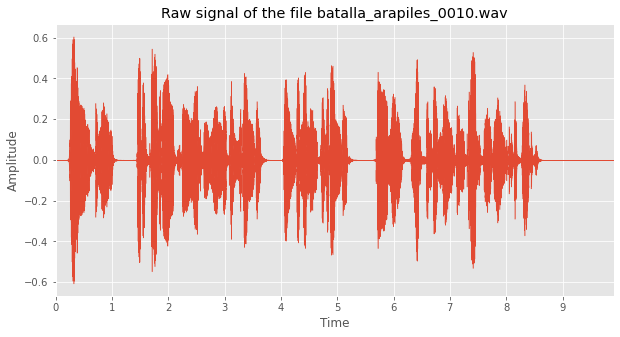

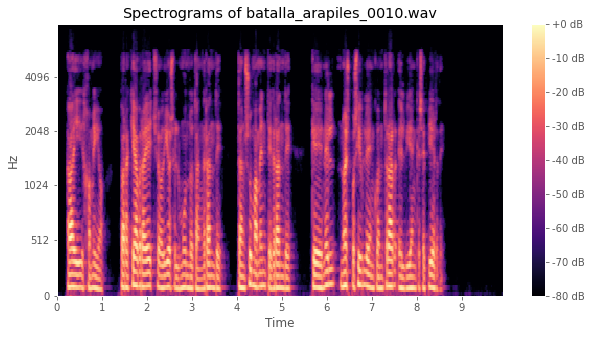

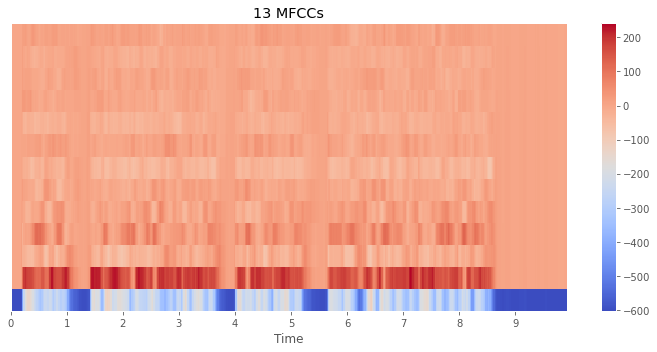

In [5]:
(waveform, sample_rate) = librosa.load('../input/spanish-single-speaker-speech-dataset/batalla_arapiles/batalla_arapiles_0010.wav')
spectrogram = librosa.feature.melspectrogram(y=waveform, sr=sample_rate)
mfccs = librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=13)
utils.plot_all(audio_data=waveform, spec=spectrogram, mfccs=mfccs, sr=sample_rate, file='batalla_arapiles_0010.wav')

### Data Pre-processing:

Before starting to analyse the data, let's do some clean up. The path which looks like 19demarzo/19marzo_XXXX.wav will be split into two other columns and thus we will have a table like this:


| index | path    |	utterance  | label   | duration	 | dir	   | file    |
|------ |---------|------------|---------|-----------|---------|---------|
|0	| 19demarzo/19demarzo_0000.wav	| Durante nuestra conversación advertí que la mu...|	Durante nuestra conversación advertí que la mu...|	5.88	| 19demarzo	|19demarzo_0000.wav |
|1|	19demarzo/19demarzo_0001.wav|	Componíanla personas de ambos sexos y de todas...|	Componíanla personas de ambos sexos y de todas...|	4.52|	19demarzo	|19demarzo_0001.wav |
|2|	19demarzo/19demarzo_0002.wav|	espontáneamente venidas por uno de esos llamam...|	espontáneamente venidas por uno de esos llamam...|	8.31|	19demarzo |	19demarzo_0002.wav |
|3|	19demarzo/19demarzo_0003.wav|	y resuenan de improviso en los oídos de un pue...|	y resuenan de improviso en los oídos de un pue...|	7.20|	19demarzo |	19demarzo_0003.wav |
|4|	19demarzo/19demarzo_0004.wav|	La campana de ese arrebato glorioso no suena s...|	La campana de ese arrebato glorioso no suena s...|	7.50|	19demarzo |	19demarzo_0004.wav |





### Clearing up unnecessary data

It is clear that there are accents, commas, etc. that we don't really care about. So, let's clear those up.
We will also clearup the data where the utterance is empty with the command d.dropna.


## Processing the audio data.
For the audio, I need to get the spectrogram or mfccs and the utterance (as the label).
The custom dataset saved as a utility script as speechdataset was created following the Custom Dataset tutorial by pytorch:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

**The utility script can be found named as speechdataset.**

In [6]:
def load_dataset(csv_file, root_dir):
  
  # Create the dataset and split into validation dataset and test dataset.
    total_dataset = speechdataset.SpanishSpeechDataSet(csv_file=csv_file, root_dir=root_dir)
    train_size = int(0.8 * len(total_dataset))
    val_test_size = len(total_dataset) - train_size
    train_dataset, val_test_dataset = torch.utils.data.random_split(total_dataset, [train_size, val_test_size])
    valid_size = int(0.9 * len(val_test_dataset))
    test_size = len(val_test_dataset) - valid_size
    val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [valid_size, test_size])
    print("Total Training Dataset = {}, Valid Dataset = {} and Test Dataset = {}".format(len(train_dataset),len(val_dataset), len(test_dataset) ))
    sample = train_dataset[0]
    print("*****Showing spectorgram with label:**** \n")
    print(sample[1])
    utils.plot_spec(sample[0], title="Mel spectrogram")
    return (train_dataset, val_dataset, test_dataset)




### Pad the data
As the audio files have different lengths. We need to pad the data and create batches. 

For example if the batch size = 3
 spec1 = [1 2 3 4 5]
 spec2 = [6 7 8]
 spec3 = [9 3]
data_processing function will create batches like:

1 batch:
[1 2 3 4 5]
[6 7 8 0 0]
[9 3 0 0 0]

In [7]:

# The following code will be for collat_fn for the pytorch dataloader function    
def data_processing(audio_data):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    #print("data processing")
    for (spec,label) in audio_data:
        #The spectrogram is in (128, 407) and (128, 355) for example but later on for padding the function expects (407, 128) and (355, 128). So we need to transpose the matrices.
        spectrograms.append(torch.Tensor(spec.transpose()))
        t = textprocessor.TextProcessor()
        label = torch.Tensor(t.text2int(text=label))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))
    #print("Start padding")
    spec_pad = torch.nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2,3)   #(batch, channel=1, features, time )
    label_pad = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True)
    #print("Finish padding")
    return spec_pad, label_pad, input_lengths, label_lengths



### Create the data loaders for training, validation and testing.

In [8]:

def create_data_loaders(train_dataset, val_dataset, test_dataset, kwargs, batch_size):
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,shuffle=True,drop_last=True, collate_fn=lambda x: data_processing(x), **kwargs )
    valid_loader = DataLoader(dataset=val_dataset, batch_size=batch_size,shuffle=False,drop_last=True, collate_fn=lambda x: data_processing(x), **kwargs)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,shuffle=False,drop_last=True, collate_fn=lambda x: data_processing(x), **kwargs)
    return (train_loader, valid_loader, test_loader)

### Training

Ready for training and validating. Using earling stopping using the library from --> https://github.com/Bjarten/early-stopping-pytorch/

We will set up the patience to 15


In [9]:

def train(n_epochs, train_loader, valid_loader, model, criterion, clip, device, lr, batch_size, save_model_path, save_pkl_path, show_every_n_batch=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, 
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=n_epochs,
                                            anneal_strategy='linear')
    train_data_len = len(train_loader.dataset)
    valid_data_len = len(valid_loader.dataset)
    epoch_train_loss = 0
    epoch_val_loss = 0
    train_losses = []
    valid_losses = []
    early_stopping = EarlyStopping(patience=20, verbose=True)
    print("#######################")
    print("#  Start Training    #")
    print("#######################")
    model.train()
    for e in range(n_epochs):
        t0 = time.time()
        #Initialize hidden state
        h = model.init_hidden(batch_size, device)
        #batch loop
        running_loss = 0.0
        for batch_idx, _data in enumerate(train_loader, 1):
            specs, labels, input_lengths, label_lengths = _data
            specs, labels = specs.to(device), labels.to(device)
            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = h.detach()
            # zero accumulated gradients
            model.zero_grad()
            # get the output from the model
            output, h = model(specs, h)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0,1)
            # calculate the loss and perform backprop
            loss = criterion(output, labels.float(), input_lengths, label_lengths)
            loss.backward()
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            scheduler.step()
            # loss stats
            running_loss += loss.item() * specs.size(0)        
        t_t = time.time() - t0

            
        ######################    
        # validate the model #
        ######################
        with torch.no_grad():
            model.eval() 
            tv = time.time()
            running_val_loss = 0.0
            for batch_idx_v, _data in enumerate(valid_loader, 1):
                specs, labels, input_lengths, label_lengths = _data
                specs, labels = specs.to(device), labels.to(device)
                val_h = model.init_hidden(batch_size, device)
                output, val_h = model(specs, val_h)
                output = F.log_softmax(output, dim=2)
                output = output.transpose(0,1)
                val_loss = criterion(output, labels.float(), input_lengths, label_lengths)
                running_val_loss += val_loss.item() * specs.size(0)
            print("Epoch {}: Training took {:.2f} [s]\tValidation took: {:.2f} [s]\n".format(e+1, t_t, time.time() - tv))
                
                
        epoch_train_loss = running_loss / train_data_len
        epoch_val_loss = running_val_loss / valid_data_len
        train_losses.append(epoch_train_loss)
        valid_losses.append(epoch_val_loss)
        print('Epoch: {} Losses\tTraining Loss: {:.6f}\tValidation Loss: {:.6f}'.format(
                e+1, epoch_train_loss, epoch_val_loss))
        model.train()
        
        print("-------------------------------------------------------------------------------------------")
        print('Epoch {} took total {} seconds'.format(e+1, time.time() - t0))
        print("-------------------------------------------------------------------------------------------")
        early_stopping(epoch_val_loss, model)
        if early_stopping.early_stop:
            print("***Early stopping***")
            break
    with open(save_pkl_path, 'wb') as f:       #this will save the list as "results.pkl" which you can load in later 
        pkl.dump((epoch_train_loss, epoch_val_loss), f)
    utils.save_model(save_path=save_model_path, model=model)
    utils.save_checkpoint(save_path=save_model_path, model=model, optimizer=optimizer, epoch=e, loss=train_losses)
    return (model, train_losses, valid_losses)

### Test Model

Calculation of WER and CER is done using the code from deepspeech. The average WER and CER is displayed at the end of the test.
Greedydecoder is used to decode the predicted char.

In [10]:
def test_model(test_data, model, model_name,device, batch_size):
    model.eval()
    print("#######################")
    print("# Testing Model: {} #".format(model_name))
    print("#######################\n\n")
    test_cer, test_wer = [], []
    test_loss = 0.0
    with torch.no_grad():
        for batch_idx, _data in enumerate(test_data, 1):
            specs, labels, input_lengths, label_lengths = _data
            #print(len(specs))
            specs, labels = specs.to(device), labels.to(device)
            # initialize the hidden state
            batch_size = specs.size(0)
            h = model.init_hidden(batch_size, device)
            # get the output of the rnn
            output, _ = model(specs, h)    
            # get the probabilities
            p = F.softmax(output, dim=2)
            output = output.transpose(0,1) #(time, batch,n_class)
            loss = criterion(output, labels, input_lengths, label_lengths)
            #Input should be [batch, time, n_classes]
            output = output.transpose(1,0)
            test_loss += loss.item() / len(test_loader)
            (decoded_preds, decoded_targets) = textprocessor.GreedyDecoder(output, labels, label_lengths)
            for j in range(len(decoded_preds)):
                print("****************************************************************************")
                print("Predicted -- {}".format(decoded_preds[j]))
                print("Utterance -- {}\n\n".format(decoded_targets[j]))
                test_cer.append(textprocessor.cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(textprocessor.wer(decoded_targets[j], decoded_preds[j]))
                utils.write_to_csv('/kaggle/working/'+model_name + '.csv', decoded_preds[j], decoded_targets[j], test_loss)
    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))                           
    

    

In [11]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.manual_seed(7)
device = torch.device("cuda" if use_cuda else "cpu")

In [12]:
input_size = 128
n_classes = 29
hidden_dim = 512
n_layers = 2
clip=5 # gradient clipping

lr = 5e-4
epochs = 27
batch_size=32

criterion = nn.CTCLoss(blank=28, zero_infinity=True)

Total Training Dataset = 8812, Valid Dataset = 1983 and Test Dataset = 221
*****Showing spectorgram with label:**** 

y godoy se fue y carlos abdico despues fernando septimo puso sus tropas en manos de napoleon


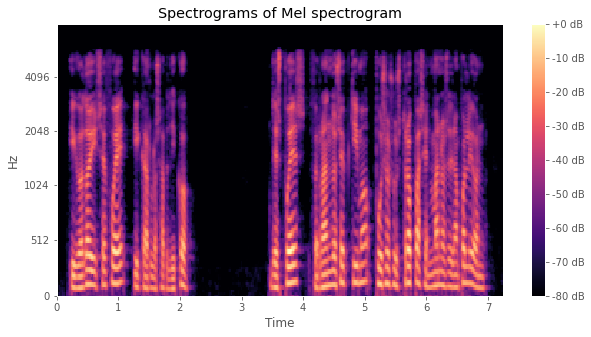

In [13]:

kwargs={'num_workers': 4, 'pin_memory': True} if use_cuda else {}
(train_dataset, val_dataset, test_dataset) = load_dataset(csv_file=CSV_FILE_PATH, root_dir=ROOT_FOLDER)
(train_loader, valid_loader, test_loader) = create_data_loaders(train_dataset, val_dataset, test_dataset, kwargs=kwargs, batch_size=batch_size)
    

In [14]:
my_birnn_net = models.SpeechRecognitionRNN(input_size, n_classes, hidden_dim, n_layers, layer_norm=True, bidir=True)
my_birnn_net.apply(models.weight_init)
conv_bigru_net = models.ASRConvBiGRU(in_channel=1, gru_input_size=512, hidden_dim=512, n_layers=5, n_feats=128, n_classes=n_classes, drop_prob=0.2)
conv_bigru_net.apply(models.weight_init)
my_birnn_net.to(device)
conv_bigru_net.to(device)
print(my_birnn_net)
print(conv_bigru_net)

SpeechRecognitionRNN(
  (gru): GRU(128, 512, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=29, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
ASRConvBiGRU(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fully_connected): Linear(in_features=2048, out_features=512, bias=True)
  (gru): GRU(512, 512, num_layers=5, batch_first=True, dropout=0.2, bidirectional=True)
  (classifier): Linear(in_features=1024, out_features=29, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [15]:

(birnn_model, birnn_train_losses, birnn_val_losses) = train(n_epochs=epochs, train_loader=train_loader, valid_loader=valid_loader,
                                                     model=my_birnn_net, criterion=criterion, clip=clip,
                                                     device=device, lr=lr, batch_size=batch_size,
                                                     save_model_path=SAVE_RESULTS_PATH+"rnn",
                                                    save_pkl_path=SAVE_MODELS_PATH + "training_rnn_iteration.pkl")


#######################
#  Start Training    #
#######################
Epoch 1: Training took 157.45 [s]	Validation took: 30.24 [s]

Epoch: 1 Losses	Training Loss: 0.330736	Validation Loss: 0.294599
-------------------------------------------------------------------------------------------
Epoch 1 took total 187.69153237342834 seconds
-------------------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.294599).  Saving model ...
Epoch 2: Training took 141.57 [s]	Validation took: 28.04 [s]

Epoch: 2 Losses	Training Loss: 0.302662	Validation Loss: 0.278109
-------------------------------------------------------------------------------------------
Epoch 2 took total 169.6074140071869 seconds
-------------------------------------------------------------------------------------------
Validation loss decreased (0.294599 --> 0.278109).  Saving model ...
Epoch 3: Training took 136.84 [s]	Validation took: 29.59 [s]

Epoch: 3 Losses	Tra

In [16]:
test_model(test_loader, birnn_model, "Layer-BI-RNN",device, batch_size=batch_size)

#######################
# Testing Model: Layer-BI-RNN #
#######################


****************************************************************************
Predicted -- ye eneaea er a eareortooreaoo
Utterance -- y algunos jinetes de la guardia se colocaron a derecha e izquierda de la puerta


****************************************************************************
Predicted -- pe a e a aie snsneess
Utterance -- por que no decirlo detesto las gazmonerias y melindres


****************************************************************************
Predicted -- a e s ei anainis esesesiais iesai ia i ene e e eseiae
Utterance -- aquella borrachera de entusiasmo no producia en nuestros oidos mas impresion que el vuelo de un insignificante insecto


****************************************************************************
Predicted -- ase a a s o eaoaia a sis o ei is sa s a a a os as a aearosos sei esaecpesesanona e a a e e esesesesss
Utterance -- hasta fuera de la villa fue en nuestra

In [17]:

(convbigru_model, conv_bigru_train_losses, conv_bigru_valid_losses) = train(n_epochs=epochs, train_loader=train_loader, valid_loader=valid_loader,
                                                                          model=conv_bigru_net, criterion=criterion, clip=clip,
                                                                          device=device, lr=lr, batch_size=batch_size,
                                                                          save_model_path=SAVE_RESULTS_PATH+"/conv_bigru",
                                                                          save_pkl_path=SAVE_MODELS_PATH + "/training_conv_bigru_results.pkl")


#######################
#  Start Training    #
#######################
Epoch 1: Training took 149.15 [s]	Validation took: 28.43 [s]

Epoch: 1 Losses	Training Loss: 0.310154	Validation Loss: 0.288712
-------------------------------------------------------------------------------------------
Epoch 1 took total 177.5842320919037 seconds
-------------------------------------------------------------------------------------------
Validation loss decreased (inf --> 0.288712).  Saving model ...
Epoch 2: Training took 148.40 [s]	Validation took: 27.77 [s]

Epoch: 2 Losses	Training Loss: 0.287672	Validation Loss: 0.277235
-------------------------------------------------------------------------------------------
Epoch 2 took total 176.16771936416626 seconds
-------------------------------------------------------------------------------------------
Validation loss decreased (0.288712 --> 0.277235).  Saving model ...
Epoch 3: Training took 149.79 [s]	Validation took: 27.79 [s]

Epoch: 3 Losses	Tra

In [18]:
test_model(test_loader, convbigru_model, "CONV-BI-RNN", device, batch_size=batch_size)

#######################
# Testing Model: CONV-BI-RNN #
#######################


****************************************************************************
Predicted -- ya lgenos ens de boaba erulara n aderch ay cie de de la corta
Utterance -- y algunos jinetes de la guardia se colocaron a derecha e izquierda de la puerta


****************************************************************************
Predicted -- porque mo e herlo desteo adade madadeda sises esesinteses
Utterance -- por que no decirlo detesto las gazmonerias y melindres


****************************************************************************
Predicted -- aquelogratedar entechas no o outandos o e o no onosien en eieienenineitietenteane
Utterance -- aquella borrachera de entusiasmo no producia en nuestros oidos mas impresion que el vuelo de un insignificante insecto


****************************************************************************
Predicted -- as a perlarela bila perdes ua cja ca a a a a e e e e e ea 

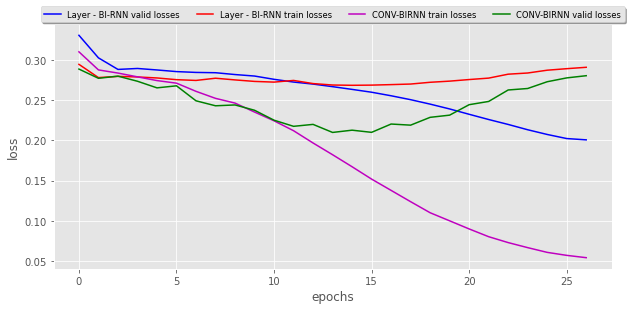

In [19]:

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
box = ax.get_position()

ax.plot(birnn_train_losses, 'b',label='Layer - BI-RNN valid losses')
ax.plot(birnn_val_losses, 'r',label='Layer - BI-RNN train losses')

ax.plot(conv_bigru_train_losses, 'm', label='CONV-BIRNN train losses')
ax.plot(conv_bigru_valid_losses, 'g', label='CONV-BIRNN valid losses')


plt.xlabel('epochs')
plt.ylabel('loss')

ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
# Put a legend above current axis
ax.legend(loc='upper center',fontsize='small', bbox_to_anchor=(0.5, 1.09),
          fancybox=True, shadow=True, ncol=4) 
# Limits for the Y axis
plt.show()